# Прогнозирование потребления электричества
Источник: https://github.com/vgarshin/arkh_lab В.Гаршин для Архипелаг2035 (2020г.)

In [40]:
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

In [41]:
pd.set_option('display.max_columns', None)
MODEL_PATH = './models'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

print('Версия tensorflow:', tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('Устройсва GPU:', gpu_device)
else:
    print('Не найдено GPU')


Версия tensorflow: 2.3.0
Не найдено GPU


In [42]:
# Устанавливаем случайное число для воспроизводимости обучения
def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds(27)

In [43]:
# Загружаем данные
df = pd.read_csv('cpt_power_data.csv', sep='\t', encoding='utf-8', index_col=0)
df['timestamp_value'] = pd.to_datetime(df['timestamp_value'])

In [54]:
# Выбираем первый источник данных для прогноза
ch_serial = df['measuringpoint_serial'].unique()[0]
channel = pd.DataFrame(
    data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
    index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
)
channel.columns = ['pwr']
print('Размерность', channel.shape)
channel.head()

Размерность (4416, 1)


,pwr
2018-03-01 00:00:00,87.8
2018-03-01 00:30:00,87.4
2018-03-01 01:00:00,88.4
2018-03-01 01:30:00,88.8
2018-03-01 02:00:00,88.0


### Обогащение данными: признаки дней недели

In [55]:
channel['n_day'] = channel.index.day.astype(np.int8)
channel['n_week'] = channel.index.week.astype(np.int8)
channel['n_month'] = channel.index.month.astype(np.int8)
channel['w_day'] = channel.index.weekday.astype(np.int8)
channel['is_weekend'] = (channel['w_day'] >= 5).astype(np.int8)
channel.head()

<ipython-input-55-02117ec5dfa8>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  channel['n_week'] = channel.index.week.astype(np.int8)


,pwr,n_day,n_week,n_month,w_day,is_weekend
2018-03-01 00:00:00,87.8,1,9,3,3,0
2018-03-01 00:30:00,87.4,1,9,3,3,0
2018-03-01 01:00:00,88.4,1,9,3,3,0
2018-03-01 01:30:00,88.8,1,9,3,3,0
2018-03-01 02:00:00,88.0,1,9,3,3,0


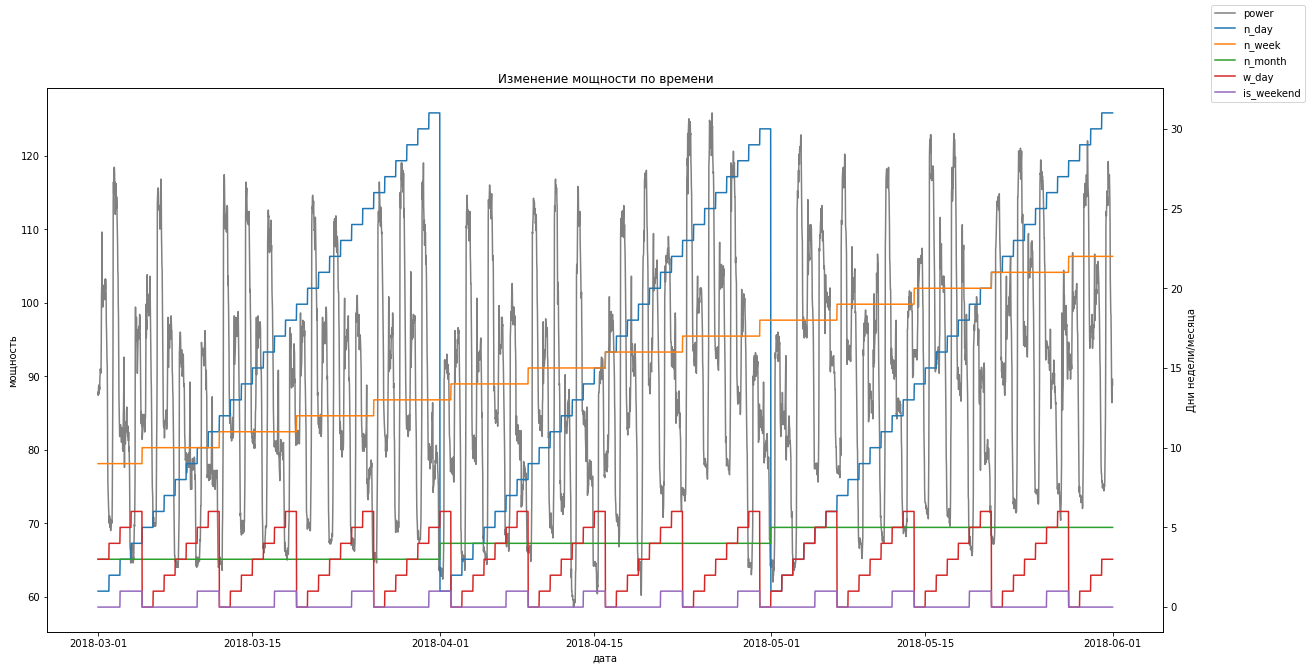

In [56]:
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.set_xlabel('дата')
ax1.set_ylabel('мощность')
ax1.plot(channel.index, channel.pwr, label='power', color='gray')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Дни недели/месяца')
for col in [x for x in channel.columns if '_' in x]:
    ax2.plot(channel.index, channel[col], label=col)
ax2.tick_params(axis='y')

fig.legend()
plt.title('Изменение мощности по времени')
plt.show()

### Base-line модель: подготовка данных

Полезная статья по LSTM для прогнозирования временных рядов https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Статья про аналогичную задачу https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [79]:
print('Подготавливаем вектор данных')
scaler, scaler_pwr = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
# Трансформируем в вертикальный вектор для построчной нормализаци и нормализуем в значения от 0 до 1.
scaler_pwr.fit(channel['pwr'].to_numpy().reshape(-1, 1))
with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'wb') as file:
    pickle.dump(scaler_pwr, file)
channelScaler = scaler.fit_transform(channel)
print('Всего рядов данных:', len(channelScaler))
print('Примеры:\n', channelScaler[0], '\n',channelScaler[int(len(channelScaler)/2)], '\n', channelScaler[-1])


Подготавливаем вектор данных
Всего рядов данных: 4416
Один ряд было:              pwr  n_day  n_week  n_month  w_day  is_weekend
2018-03-01  87.8      1       9        3      3           0                       pwr  n_day  n_week  n_month  w_day  is_weekend
2018-05-31 23:30:00  88.8     31      22        5      3           0
Cтало:
 [0.43452381 0.         0.         0.         0.5        0.        ] 
 [0.30952381 0.5        0.53846154 0.5        0.         0.        ] 
 [0.44940476 1.         1.         1.         0.5        0.        ]


In [80]:
def get_dataset(series, col_look, look_back, look_fwd, cols_features):
    X, y = [], []
    for i in range(len(series[:, col_look]) - look_back - look_fwd):
        temp_X = []
        temp_X.append(series[:, col_look][i:(i + look_back)])
        for col in cols_features:
            temp_X.append(series[:, col][(i + look_fwd):(i + look_back + look_fwd)])
        X.append(temp_X)
        y.append(series[:, col_look][(i + look_back):(i + look_back + look_fwd)])
    return np.array(X), np.array(y)

In [83]:
look_fwd = 7 * 24 * 2 # days * hours * half an hour
print('Прогноз на рядов (дней * часов * полчаса):', look_fwd)
look_back = 2 * look_fwd
print('Обучаем на рядах (прогноз х2):', look_back)
X, y = get_dataset(channelScaler, 0, look_back, look_fwd, [1, 2, 3, 4, 5])
print('X shape:', X.shape, '| y shape:', y.shape)
print('Пример обучающей выборки:', X[0][:, 0])

Прогноз на рядов (дней * часов * полчаса): 336
Обучаем на рядах (прогноз х2): 672
X shape: (3408, 6, 672) | y shape: (3408, 336)
Пример обучающей выборки: [0.43452381 0.23333333 0.07692308 0.         0.5        0.        ]


In [86]:
def get_train_test(X, y, test_size=.25):
    cut = int((1 - test_size) * len(y))
    X_train, y_train = X[:cut], y[:cut]
    X_test, y_test = X[cut:], y[cut:]

    # LSTM feed [samples, time steps, features]
    print('as is:')
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    print('\nreshaped to LSTM pattern [samples, time steps, features]:')
    X_train = np.array([x.T for x in X_train])
    X_test = np.array([x.T for x in X_test])
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)

    return X_train, y_train, X_test, y_test

In [87]:
X_train, y_train, X_test, y_test = get_train_test(X, y, test_size=.25)
# показывает данные по дням параметрам
# чтобы упростить сеть
# регресионный анализ значимости и корреляции параметров
# корелейшен тест и мешаем признаки и смотрим как модель отработает, если ухудшилась - параметр значим
# для оптимизации можно использовать градиентный бурстинг


as is:
	X train shape: (2556, 6, 672) | X test shape: (852, 6, 672)
	y train shape: (2556, 336) | y test shape: (852, 336)

reshaped to LSTM pattern [samples, time steps, features]:
	X train shape: (2556, 672, 6) | X test shape: (852, 672, 6)
	y train shape: (2556, 336) | y test shape: (852, 336)


### Base-line модель: обучение

In [88]:
def get_model(units, n_features,
              dropout, r_dropout,
              look_back, look_fwd,
              stack=False, loss='mse'):
    model = Sequential()
    if stack:
        model.add(LSTM(units=units,
                       input_shape=(look_back, n_features),
                       return_sequences=True,
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
        model.add(LSTM(units=units,
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
    else:
        model.add(LSTM(units=units,
                       input_shape=(look_back, n_features),
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
    model.add(Dense(look_fwd))
    model.add(Activation('linear'))
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=adam)
    return model

In [89]:
model = get_model(
    units=256,  # кол-во нейронов
    n_features=6,  # кол-во входных параетров
    dropout=.4,
    r_dropout=0,
    look_back=look_back,
    look_fwd=look_fwd,
    stack=False,
    loss='mse'
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               269312    
_________________________________________________________________
dense (Dense)                (None, 336)               86352     
_________________________________________________________________
activation (Activation)      (None, 336)               0         
Total params: 355,664
Trainable params: 355,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
checkpoint_path = f'{MODEL_PATH}/model.hdf5'
earlystopper = EarlyStopping( # Если качество не растет в течении 40 эпох - будет переобучаться
    monitor='val_loss',
    patience=40,
    verbose=1,
    mode='min'
)
lrreducer = ReduceLROnPlateau( # Уменьшает лернин рейт, если в течении определенном уровне качества стабильно
    monitor='val_loss',
    factor=.1,
    patience=20,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)
checkpointer = ModelCheckpoint( # Сохраняет наилучшую модель, в случае сбоя продолжить.
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)
callbacks = [earlystopper, checkpointer, lrreducer] # Для проверки что сеть не переобучилась и качество улучшается
history = model.fit(
    X_train, y_train,
    epochs=40, # #######1000,
    batch_size=64, # ####128,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=callbacks,
    shuffle=False
)
# Для ускорения можно чуть уменьшить эпохки (для теста 20-40) и уменьшить батчи, например до 64

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 0.0545  

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16, 4))
y_pred = model.predict(X_test[0:1])[0]
plt.plot(y_test[0], label='true')
plt.plot(y_pred, label='predict')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test[0:1])[0]

with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'rb') as f:
    scaler_pwr = pickle.load(f)

plt.figure(figsize=(16, 4))
past = range(len(X_train[0][:, 0]))
future = range(len(X_train[0][:, 0]), len(X_train[0][:, 0]) + len(y_test[0]))
plt.plot(past,
         scaler_pwr.inverse_transform(X_train[-1][:, 0].reshape(-1, 1)),
         label='train')
plt.plot(future,
         scaler_pwr.inverse_transform(y_test[0].reshape(-1, 1)),
         label='true')
plt.plot(future,
         scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)),
         label='predict')
plt.legend()
plt.show()

In [ ]:
channel_ = pd.DataFrame(
    data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
    index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
)
plt.figure(figsize=(16, 4))
start_point = len(X_train) + look_back
plt.plot(channel_[(start_point - 2 * look_back):(start_point + len(y_pred))],
         label='true')
plt.plot(channel_.index[start_point:(start_point + len(y_pred))],
         scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)),
         label='predict')
plt.legend()
plt.show()
